# run original version of hickit

In [1]:
# [M::main] CMD: hickit -s42 -M -i mESCP2H3K27me3073.impute.pairs.gz -Sr1m -c1 -r10m -c2 -b4m -b1m -O mESCP2H3K27me3073.1m.42.3dg -b200k -O mESCP2H3K27me3073.200k.42.3dg
# [M::main] CPU time: 1409.716 sec

In [24]:
import sys
sys.path.append("/shareb/zliu/analysis/")
sys.path.append("/shareb/zliu/analysis/CHARMtools/")
from CHARMtools import Cell3D
from CHARMtools import CHARMio

import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tqdm

In [25]:
cell = Cell3D.Cell3D(cellname= "mESCP2H3K27me3073",tdg_path="./data/mESCP2H3K27me3073.1m.42.3dg",resolution=1000000)
cell.add_chrom_length(chrom_length_path="/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")

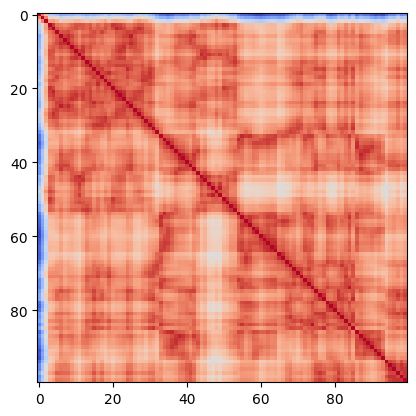

In [26]:
plt.imshow(cell.calc_distance_matrix(genome_coord="chr1a")[0:100,0:100],cmap="coolwarm_r")

# Dev for CPU version

In [27]:
def pairs2df(pairs):
    pd.read_csv("",sep="\t")

In [28]:
data = CHARMio.parse_pairs("./data/mESCP2H3K27me3073.impute.pairs.gz")
data = data[data[['phase_prob00','phase_prob01','phase_prob10','phase_prob11']].max(axis=1)>0.9]
data["type"] = data[['phase_prob00','phase_prob01','phase_prob10','phase_prob11']].idxmax(axis=1)
data["type"] = data["type"].apply(lambda x: x.replace("0","a").replace("1","b").replace("phase_prob",""))
data["chr1"] = data["chr1"] + data["type"].apply(lambda x: x[0])
data["chr2"] = data["chr2"] + data["type"].apply(lambda x: x[1])
data = data[['chr1','pos1','chr2','pos2']]

In [29]:
resolution = 1000000
testdata = data.query('chr1 == "chr1a" & chr2 == "chr1a"')[["pos1","pos2"]]
testdata["pos1"] = testdata["pos1"] // resolution
testdata["pos2"] = testdata["pos2"] // resolution
testdata = testdata.groupby(["pos1","pos2"]).size().reset_index().rename(columns={0:"count"})
testdata["count"] = np.log2(testdata["count"] / testdata["count"].sum() * 1000 +1)

In [30]:
contacts=testdata#.values

In [31]:
chrlen = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.len",sep="\t",header=None)
chrlen.columns = ["chr","len"]

In [32]:
num_points=chrlen["len"].values[0]//resolution+1
#num_points=15

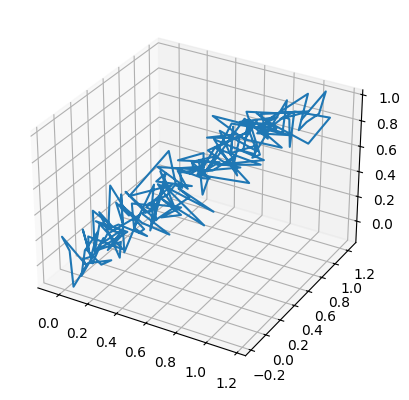

In [33]:
# initialize points as a line 
points = np.zeros((num_points, 3))
points[:, 0] = np.linspace(0, 1, num_points)
points[:, 1] = np.linspace(0, 1, num_points)
points[:, 2] = np.linspace(0, 1, num_points)
# add noise
np.random.seed(42)
points += np.random.normal(0, 0.1, points.shape)

# plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# line plot
#ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.plot(points[:, 0], points[:, 1], points[:, 2])
#for c in contacts.itertuples():
    #ax.plot([points[c[0], 0], points[c[1], 0]], [points[c[0], 1], points[c[1], 1]], [points[c[0], 2], points[c[1], 2]], 'r')
#    ax.plot([points[c[1], 0], points[c[2], 0]], [points[c[1], 1], points[c[2], 1]], [points[c[1], 2], points[c[2], 2]], 'r')
plt.show()

In [34]:
class KDNode:
    def __init__(self, point, left=None, right=None):
        self.point = point
        self.left = left
        self.right = right

def build_kdtree(points, depth=0):
    n = len(points)
    if n == 0:
        return None
    k = points.shape[1]  # Assuming all points have the same dimension
    axis = depth % k

    # Median of points sorted by the current axis
    indices = np.argsort(points[:, axis])
    median_idx = n // 2

    # Create node and construct subtrees using indices to avoid data copy
    return KDNode(
        point=points[indices[median_idx]],
        left=build_kdtree(points[indices[:median_idx]], depth + 1),
        right=build_kdtree(points[indices[median_idx + 1:]], depth + 1)
    )

def distance_squared(point1, point2):
    return np.sum((np.array(point1) - np.array(point2)) ** 2)

def query_kdtree(root, point, radius, depth=0):
    if root is None:
        return []
    k = len(point)
    axis = depth % k
    points = []
    
    # Check the distance to the point in this node
    if np.sum((np.array(root.point) - np.array(point)) ** 2) <= radius**2:
        points.append(root.point)
    
    # Determine which branch to search
    next_branch = None
    opposite_branch = None
    if point[axis] < root.point[axis]:
        next_branch = root.left
        opposite_branch = root.right
    else:
        next_branch = root.right
        opposite_branch = root.left
    
    # Search the next branch
    points.extend(query_kdtree(next_branch, point, radius, depth + 1))
    
    # Check whether we should search the opposite branch
    if (point[axis] - root.point[axis])**2 <= radius**2:
        points.extend(query_kdtree(opposite_branch, point, radius, depth + 1))
    
    return points


def calc_forces(points, contacts, k_backbone=1, k_repulsion=1, k_contact=1, rep_dist = 1.5,kd_tree="scipy"):
    num_points = points.shape[0]
    forces = np.zeros((num_points, 3))
    
    # Vectorized backbone forces calculation
    diffs = points[1:] - points[:-1]
    dists = np.linalg.norm(diffs, axis=1)
    diffs /= dists[:, None]  # Normalize
    force_magnitudes = k_backbone * (dists - 1)
    forces[:-1] += (force_magnitudes[:, None] * diffs)
    forces[1:] += (force_magnitudes[:, None] * diffs)

    if kd_tree == "scipy":
        tree = cKDTree(points)
    else:
        tree = build_kdtree(points)
    for i in range(num_points):
        if kd_tree == "scipy":
            idx = tree.query_ball_point(points[i], r=rep_dist)
        else:
            idx = query_kdtree(tree, points[i], rep_dist)
        for j in idx:
            if i < j:  
                diff = points[i] - points[j]
                dist = np.linalg.norm(diff)
                if dist > 0:
                    force = k_repulsion * diff / (dist * dist * dist)  
                    forces[i] += force
                    forces[j] -= force

    # Calculate contact forces
    for c in contacts.itertuples():  # Assuming contacts is a DataFrame
        ind1, ind2, count = c.pos1, c.pos2, c.count
        diff = points[ind1] - points[ind2]
        dist = np.linalg.norm(diff)
        diff = diff / dist
        if dist > 0:
            forces[ind1] -= k_contact * diff * dist * count
            forces[ind2] += k_contact * diff * dist * count
    
    return forces

def fdg(points, contacts, k_backbone=1, k_repulsion=1, k_contact=1, rep_dist=2,num_iter=500, lr=1):
    points = points.copy()
    num_points = points.shape[0]
    for i in tqdm.tqdm(range(num_iter)):
        forces = calc_forces(points, contacts, k_backbone, k_repulsion, k_contact, rep_dist)
        points += lr * forces
        #print(points)
        # print RMS force
        if i % 100 == 0:
            print(np.sqrt(np.mean(forces**2)))
    return points

In [36]:
np.random.seed(42)
fdg_points = fdg(points, contacts,
                 k_backbone=1, k_repulsion=1, k_contact=1, rep_dist=3, num_iter=400, lr=0.05)

  0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_3644449/3404135861.py:94: RuntimeWarning: invalid value encountered in divide
  diff = diff / dist
  1%|          | 3/400 [00:00<01:15,  5.25it/s]

4275.866674898817


 26%|██▌       | 103/400 [00:09<00:27, 10.97it/s]

1.6931611672259272


 51%|█████     | 203/400 [00:18<00:17, 11.12it/s]

0.6004361096718408


 76%|███████▌  | 303/400 [00:27<00:08, 11.16it/s]

0.3834757126984353


100%|██████████| 400/400 [00:35<00:00, 11.12it/s]


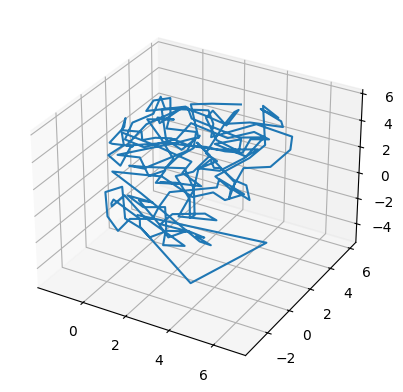

In [37]:
# plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# line plot
#ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.plot(fdg_points[:, 0], fdg_points[:, 1], fdg_points[:, 2])
#for c in contacts.itertuples():
    #ax.plot([points[c[0], 0], points[c[1], 0]], [points[c[0], 1], points[c[1], 1]], [points[c[0], 2], points[c[1], 2]], 'r')
#    ax.plot([fdg_points[c[1], 0], fdg_points[c[2], 0]], [fdg_points[c[1], 1], fdg_points[c[2], 1]], [fdg_points[c[1], 2], fdg_points[c[2], 2]], 'r')
plt.show()

Text(0.5, 1.0, 'hickit distance matrix')

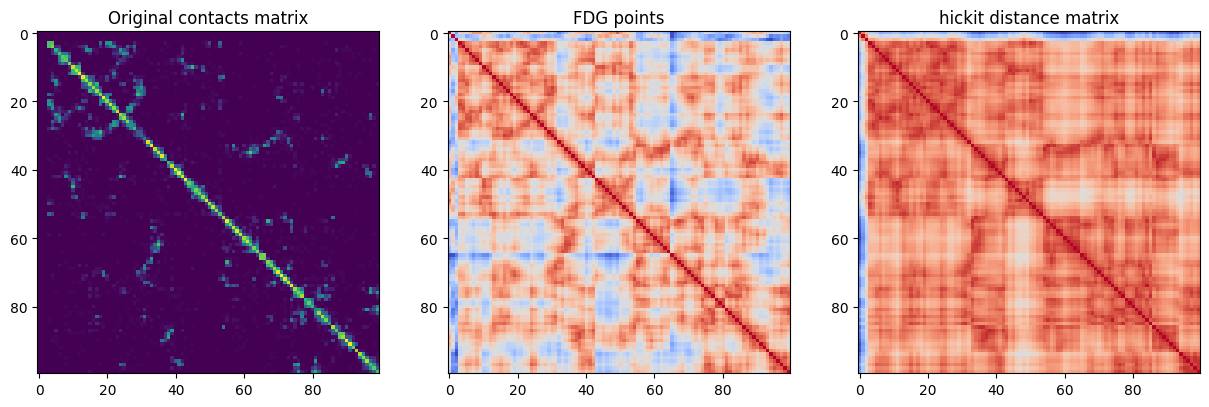

In [38]:
# contacts matrix, distance matrix of fdg_points, side by side
from scipy.spatial.distance import pdist, squareform

contacts_matrix= np.zeros((num_points, num_points))
for c in contacts.iterrows():
    #contacts_matrix[c[0], c[1]] = c[2]
    #contacts_matrix[c[1], c[0]] = c[2]
    ind1,ind2,count = c[1]
    ind1 = int(ind1)
    ind2 = int(ind2)
    contacts_matrix[ind1, ind2] = count
    contacts_matrix[ind2, ind1] = count

dist_fdg = squareform(pdist(fdg_points))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(contacts_matrix[:100, :100],vmax=2)
ax[0].set_title('Original contacts matrix')
ax[1].imshow(dist_fdg[:100, :100],cmap="coolwarm_r")#,vmin=0,vmax=1e50)
ax[1].set_title('FDG points')
ax[2].imshow(cell.calc_distance_matrix(genome_coord="chr1a")[:100, :100],cmap="coolwarm_r")
ax[2].set_title('hickit distance matrix')


In [39]:
Cell3D.mat_cor_with_na(dist_fdg,cell.calc_distance_matrix(genome_coord="chr1a"))

[0.8014428067965637, 0.8892396710515189]

# GPU

In [58]:
import cupy as cp
import cupyx.scipy.spatial
import tqdm

def calc_forces(points, contacts, k_backbone=1, k_repulsion=1, k_contact=1, rep_dist=1.5, kd_tree="cupy"):
    num_points = points.shape[0]
    forces = cp.zeros((num_points, 3))
    
    # Vectorized backbone forces calculation
    diffs = points[1:] - points[:-1]
    dists = cp.linalg.norm(diffs, axis=1)
    diffs /= dists[:, None]  # Normalize
    force_magnitudes = k_backbone * (dists - 1)
    forces[:-1] += (force_magnitudes[:, None] * diffs)
    forces[1:] -= (force_magnitudes[:, None] * diffs)


    tree = cupyx.scipy.spatial.KDTree(points)

    for i in range(num_points):
        idx = tree.query_ball_point(points[i], r=rep_dist)
        for j in idx:
            if i < j:  
                diff = points[i] - points[j]
                dist = cp.linalg.norm(diff)
                if dist > 0:
                    force = k_repulsion * diff / (dist * dist * dist)  
                    forces[i] += force
                    forces[j] -= force

    # Calculate contact forces
    for c in contacts.itertuples():  # Assuming contacts is a DataFrame
        ind1, ind2, count = c.pos1, c.pos2, c.count
        diff = points[ind1] - points[ind2]
        dist = cp.linalg.norm(diff)
        diff /= dist
        if dist > 0:
            forces[ind1] -= k_contact * diff * dist * count
            forces[ind2] += k_contact * diff * dist * count
    
    return forces

def fdg(points, contacts, k_backbone=1, k_repulsion=1, k_contact=1, rep_dist=2, num_iter=500, lr=1):
    points = cp.asarray(points)  # Ensure points are on GPU
    contacts = cp.asarray(contacts)  # Adjust if contacts is not a DataFrame
    num_points = points.shape[0]
    for i in tqdm.tqdm(range(num_iter)):
        forces = calc_forces(points, contacts, k_backbone, k_repulsion, k_contact, rep_dist)
        points += lr * forces
        # Print RMS force every 100 iterations
        if i % 100 == 0:
            print(cp.sqrt(cp.mean(forces**2)))
    return points


In [59]:
points_gpu = torch.tensor(points, device='cuda', dtype=torch.float32)
contacts_gpu = torch.tensor(contacts.values, device='cuda', dtype=torch.float32)

fdg_points = fdg(points_gpu, contacts, k_backbone=1, k_repulsion=1, k_contact=1, rep_dist=2, num_iter=1000, lr=0.05)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/zliu/miniforge3/envs/hic/lib/python3.10/site-packages/cupy/cuda/compiler.py:233: PerformanceWarning: Jitify is performing a one-time only warm-up to populate the persistent cache, this may take a few seconds and will be improved in a future release...
  jitify._init_module()
  0%|          | 0/1000 [01:01<?, ?it/s]


AttributeError: module 'cupyx.scipy.spatial' has no attribute 'KDTree'

Text(0.5, 1.0, 'hickit distance matrix')

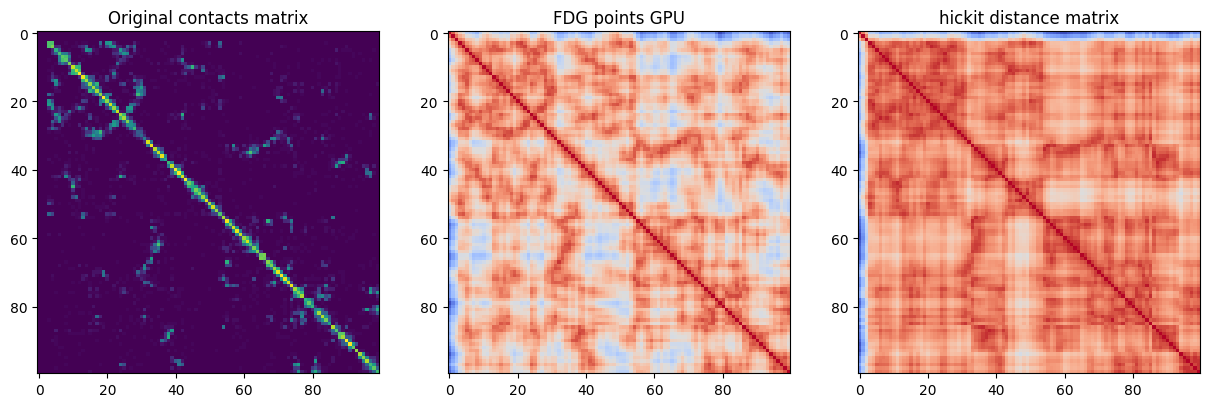

In [55]:
# contacts matrix, distance matrix of fdg_points, side by side
from scipy.spatial.distance import pdist, squareform

contacts_matrix= np.zeros((num_points, num_points))
for c in contacts.iterrows():
    #contacts_matrix[c[0], c[1]] = c[2]
    #contacts_matrix[c[1], c[0]] = c[2]
    ind1,ind2,count = c[1]
    ind1 = int(ind1)
    ind2 = int(ind2)
    contacts_matrix[ind1, ind2] = count
    contacts_matrix[ind2, ind1] = count

dist_fdg = squareform(pdist(fdg_points.cpu()))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(contacts_matrix[:100, :100],vmax=2)
ax[0].set_title('Original contacts matrix')
ax[1].imshow(dist_fdg[:100, :100],cmap="coolwarm_r")#,vmin=0,vmax=1e50)
ax[1].set_title('FDG points GPU')
ax[2].imshow(cell.calc_distance_matrix(genome_coord="chr1a")[:100, :100],cmap="coolwarm_r")
ax[2].set_title('hickit distance matrix')
